# **This notebook aims to show how to detect and classify the salad and bar elements on a new image**


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


To be able to do the detection on a new image, we create a class called YOLO. That class contains a set of methods to predict the bounding boxes and the associated classes as well as methods to display the results of the detection on a new image.

In [4]:
#Libraries importation
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Technical test - Trayvisor')
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras import backend as K
from keras.models import load_model
from keras.layers import Input

from yolo3.model import yolo_eval, yolo_body
from yolo3.utils import image_preprocess

class YOLO(object):
    '''We create a YOLO object to be able to evaluate the performances of our trained model'''

    _defaults = {
        "image_path": '/content/drive/My Drive/Colab Notebooks/Technical test - Trayvisor/images',
        "data_path": '/content/drive/My Drive/Colab Notebooks/Technical test - Trayvisor/trayvisor_test_db.npy',
        "model_path":'/content/drive/My Drive/Colab Notebooks/Technical test - Trayvisor/model_weights/trained_weights_final.h5',
        "anchors_liste": [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326],
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "text_size" : 3,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
      '''Gets the classes presents in our datasets and puts them in a list'''
      classes=[]
      data=np.load(self.data_path,allow_pickle=True)
      for number in range(len(data)):
          for i in range(len(data[number]['boxes'])):
                class_name=data[number]['boxes'][i]['id']
                if(class_name not in classes):
                    classes.append(class_name)             
      return classes

    def _get_anchors(self):
        '''Creates the anchors that will be used for the detection task'''
        return np.array(self.anchors_liste, dtype='float').reshape(-1, 2)

    def generate(self):
        '''Returns the boxes, scores and classes predicted by our covolutioal neural network'''

        assert self.model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        try:
            self.yolo_model = load_model(self.model_path, compile=False)
        except:
            self.yolo_model = yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(self.model_path))

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def BB_extraction(self,data,image_path):
      '''Extracts image name,label and Bounding Box coordinates'''
      classes=[]
      Data_info=[]

      for number in range(len(data)):
        liste=[]
        liste.append(image_path+'/'+data[number]['name'])
                      
        for i in range(len(data[number]['boxes'])):
            cord=data[number]['boxes'][i]['box']   
            cord[2]+=cord[0]
            cord[3]+=cord[1]
            class_name=data[number]['boxes'][i]['id']

            if(class_name not in classes):
                classes.append(class_name)

            cord.append(classes.index(class_name))
            
            liste.append(cord)
        Data_info.append(liste)
        
      del data
            
      return Data_info
    
    def predict(self,im_path):
      image = io.imread(im_path)
      
      if self.model_image_size != (None, None):
        assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
        assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
        boxed_image = image_preprocess(np.copy(image), tuple(reversed(self.model_image_size)))
        image_data = boxed_image
      
      out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.shape[0], image.shape[1]],#[image.size[1], image.size[0]],
                K.learning_phase(): 0
            })
      return out_boxes, out_scores, out_classes,image

    def detect_and_classify_vrac(self,im_path):
      '''Detects and classify the "salad and fruit bar" vracs presents in an image '''
      
      out_boxes, out_scores, out_classes,image = self.predict(im_path)
       
      #print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

      plt.figure(figsize=(5,5))
      plt.axis('off')
      plt.imshow(image)
      axes = plt.gca()

      for i in range(len(out_classes)):
        predicted_class = self.class_names[out_classes[i]]
        box = out_boxes[i]
        score = out_scores[i]

        ymin, xmin, ymax, xmax = box
        ymin = max(0, np.floor(ymin + 0.5).astype('int32'))
        xmin = max(0, np.floor(xmin + 0.5).astype('int32'))
        ymax = min(image.shape[0], np.floor(ymax + 0.5).astype('int32'))
        xmax = min(image.shape[1], np.floor(xmax + 0.5).astype('int32'))

        w=xmax-xmin
        h=ymax-ymin
        axes.add_artist((Rectangle((xmin, ymin), w, h, color = 'magenta',fill=False,linewidth = 2)))
        plt.text(xmin+w/2, ymin-10,predicted_class, fontsize = 10,color='magenta',fontweight = 'bold',horizontalalignment = 'center')

      plt.show()


    def ground_truth_and_prediction_visual_comparison(self,im_path):
      '''Displays side to side an image with the ground truth (real bounding boxes) as well as the predicted bounding boxes
      to visually see how the model performed compared to the reality'''

      line=self.BB_extraction(np.load(self.data_path,allow_pickle=True),self.image_path)
      info=[]
      for element in line:
        if(element[0]==im_path):
          info=element
          #print(info)
          break
      if(not info):
        print('Sorry but the absolute path of the image you specified is incorrect')

      else:
        info.remove(im_path)
        #print(info)
      
        out_boxes, out_scores, out_classes,image = self.predict(im_path)
       
        #print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.title('Prediction')
        plt.imshow(image)
        axes = plt.gca()
        plt.axis('off')

        for i in range(len(out_classes)):
          predicted_class = self.class_names[out_classes[i]]
          box = out_boxes[i]
          score = out_scores[i]

          ymin, xmin, ymax, xmax = box
          ymin = max(0, np.floor(ymin + 0.5).astype('int32'))
          xmin = max(0, np.floor(xmin + 0.5).astype('int32'))
          ymax = min(image.shape[0], np.floor(ymax + 0.5).astype('int32'))
          xmax = min(image.shape[1], np.floor(xmax + 0.5).astype('int32'))

          w=xmax-xmin
          h=ymax-ymin
          axes.add_artist((Rectangle((xmin, ymin), w, h, color = 'magenta',fill=False,linewidth = 2)))
          plt.text(xmin+w/2, ymin-10,predicted_class, fontsize = 10,color='magenta',fontweight = 'bold',horizontalalignment = 'center')
        

        plt.subplot(1,2,2)
        axes = plt.gca()
        plt.axis('off')
        plt.title('Ground Truth')
        plt.imshow(image)
        for element in info:
          xmin=element[0]
          ymin=element[1]
          xmax=element[2]
          ymax=element[3]
          #print(xmin,ymin,xmax,ymax)
          classe=element[4]
          predicted_class = self.class_names[out_classes[classe]]
          w=xmax-xmin
          h=ymax-ymin
          axes.add_artist((Rectangle((xmin, ymin), w, h, color = 'magenta',fill=False,linewidth = 2)))
          plt.text(xmin+w/2, ymin-10,predicted_class, fontsize = 10,color='magenta',fontweight = 'bold',horizontalalignment = 'center')


        plt.show()

    def close_session(self):
        self.sess.close()

Using TensorFlow backend.


The methods written below help to compute the mean average precision(mAP). The mAP is the metric we chose to evaluate our model. To compute that metric, we need to compute the intersection over union between each ground truth bounding box and their prediction and determine the recall and the precision.

In [0]:

def intersection(box1,box2):
  '''Returns the intersection between 2 boxes, box1 and box2.
  box=[xmin,ymin,xmax,ymax]'''

  x1min,y1min,x1max,y1max=box1
  x2min,y2min,x2max,y2max=box2

  xmin=max(x1min,x2min)
  xmax=min(x1max,x2max)
  ymin=max(y1min,y2min)
  ymax=min(y1max,y2max)

  w_intersect=max(0,xmax-xmin)
  h_intersect=max(0, ymax-ymin)

  return h_intersect*w_intersect

def union(box1,box2):
  '''Returns the union between 2 boxes, box1 and box2.
  box=[xmin,ymin,xmax,ymax]'''
  x1min,y1min,x1max,y1max=box1
  x2min,y2min,x2max,y2max=box2
  A1=(x1max-x1min)*(y1max-y1min)
  A2=(x2max-x2min)*(y2max-y2min)

  return A1+A2-intersection(box1,box2)

def IoU(box1,box2):
  '''Returns the intersection over union between 2 boxes, box1 and box2.
  box=[xmin,ymin,xmax,ymax]'''
  u=union(box1,box2)
  i=intersection(box1,box2)

  if(i!=0):
    return i/float(u)
  else:
    return 0

def precision_recall(iou_liste,tresh=0.5):
  '''Returns the precision and recall from a list containing
  the iou values executed over the ground truth and the predicted boxes.
  tresh is the threshold used to define True positive.'''
  TP=0
  precision=[]
  recall=[]
  total=len(iou_liste)
  for i in range(total):
    if(iou_liste[i]>=tresh):
      TP=TP+1
      precision.append(TP/float(i+1))
      recall.append(TP/float(total))
  return precision, recall

def mAP(precision,recall):
  '''Computes the mAP'''
  prec_at_rec = []
  value=np.linspace(0.0, 1.0, 11)
  for i in range(len(value)):
    prec=[0]
    for j in range(len(precision)):
      if (recall[j]>=value[i]):
        prec.append(precision[j])
    prec_at_rec.append(max(prec))
  avg_prec = np.mean(prec_at_rec)
  print('11 point precision is ', prec_at_rec)
  print('mAP is ', avg_prec)

In [0]:
def ordering(a,ind):
  '''This function arrange the elements of a list in an ascending order depending on a[ind]'''
  mini=[]
  intermediaire=[]
  for element in a:
    mini.append(element[ind])
    mini.sort()
  for i in range(len(a)):
    num=mini.index(a[i][ind])
    intermediaire=a[num].copy()
    a[num]=a[i].copy()
    a[i]=intermediaire.copy()
  return a

def evaluate(dataset,yolo):
  '''This function aims to evaluate a model by calculating the mean average precision of the model.
  dataset is either the train or the test set and yolo is a YOLO object.'''
  ioveru=[]
  bbox=[]
  bbox1=[]
  bbox2=[]
  for i in range(len(dataset)):
    pred_bbox,_,_,image=yolo.predict(dataset[i][0])
    if(len(pred_bbox)>1):
      pred_bbox=ordering(pred_bbox,1)
    for k in range(len(pred_bbox)):
      bbox.append(pred_bbox[k])

    myliste=dataset[i].copy()
    del myliste[0]
    if(len(myliste))>1:
      myliste=ordering(myliste,0)

    for j in range(len(myliste)):
      bbox1.append([myliste[j][0],myliste[j][1],myliste[j][2],myliste[j][3]])
  
  for i in range(len(bbox)):
    ymin = max(0, np.floor(bbox[i][0] + 0.5).astype('int32'))
    xmin = max(0, np.floor(bbox[i][1] + 0.5).astype('int32'))
    ymax = min(image.shape[0], np.floor(bbox[i][2] + 0.5).astype('int32'))
    xmax = min(image.shape[1], np.floor(bbox[i][3] + 0.5).astype('int32'))
    bbox2.append([xmin,ymin,xmax,ymax])
  
  for i in range(len(bbox1)):
    print(bbox1[i],bbox2[i])
    ioveru.append(IoU(bbox1[i],bbox2[i]))
  
  #print('step4')
  precision,recall=precision_recall(ioveru)
  #print(precision)
  #print(recall)

  mAP(precision,recall)

Now that our functions are defined, let's proceed to the detection phase. To do so, we first load our test set, chose some images and use the detect_and_classify_vrac on those images. Here are some visual results of the detection.

In [0]:
test=np.load("/content/drive/My Drive/Colab Notebooks/Technical test - Trayvisor/dataset2020216133642/test.npy",allow_pickle=True)
#Just to get the test set and do the prediction on some of its images.













/content/drive/My Drive/Colab Notebooks/Technical test - Trayvisor/model_weights/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


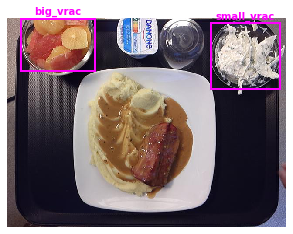

In [8]:
if __name__=="__main__":
    yolo = YOLO()
    image_path = '/content/drive/My Drive/Colab Notebooks/Technical test - Trayvisor/images/im_795.jpg'
    yolo.detect_and_classify_vrac(image_path)

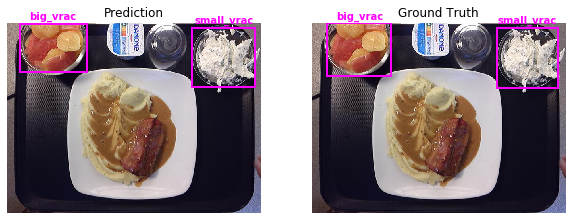

In [8]:
image_path = '/content/drive/My Drive/Colab Notebooks/Technical test - Trayvisor/images/im_795.jpg'
yolo.ground_truth_and_prediction_visual_comparison(image_path)

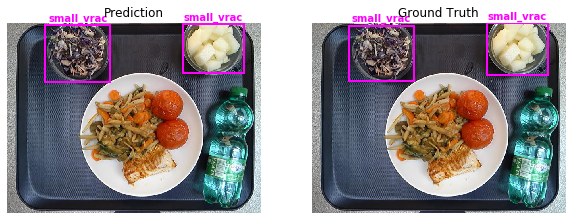

In [9]:
image_path = '/content/drive/My Drive/Colab Notebooks/Technical test - Trayvisor/images/im_527.jpg'
yolo.ground_truth_and_prediction_visual_comparison(image_path)

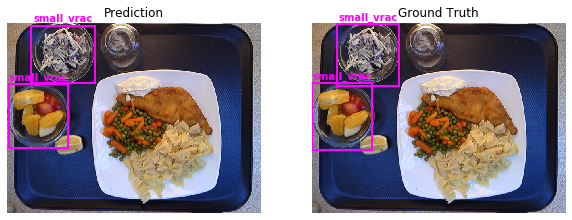

In [10]:
image_path = '/content/drive/My Drive/Colab Notebooks/Technical test - Trayvisor/images/im_893.jpg'
yolo.ground_truth_and_prediction_visual_comparison(image_path)

We compute the mAP on the test set. 

*   PS: the evaluation function is heavy and takes some time to compute the mAP when the dataset chosen is big.


In [63]:
evaluate(test,yolo)

[289, 174, 463, 348] [283, 169, 463, 354]
[286, 172, 466, 352] [282, 169, 463, 353]
[60, 0, 234, 139] [62, 3, 238, 138]
[448, 8, 604, 174] [450, 14, 608, 163]
[21, 32, 197, 208] [20, 34, 197, 209]
[0, 85, 144, 263] [0, 90, 142, 263]
[376, 172, 548, 348] [368, 169, 547, 352]
[60, 39, 230, 209] [59, 32, 229, 212]
[49, 0, 223, 134] [62, 1, 211, 126]
[4, 21, 184, 196] [13, 21, 192, 199]
[33, 0, 192, 136] [34, 0, 192, 126]
[508, 49, 640, 190] [500, 38, 637, 201]
[44, 66, 212, 223] [43, 63, 203, 221]
[246, 2, 442, 145] [253, 3, 441, 140]
[297, 21, 456, 180] [301, 24, 452, 180]
[431, 47, 594, 216] [428, 49, 592, 207]
[92, 24, 265, 197] [96, 18, 259, 197]
[0, 4, 154, 144] [2, 2, 148, 143]
[476, 0, 640, 122] [474, 0, 629, 125]
[417, 0, 581, 130] [420, 4, 575, 123]
[113, 34, 270, 191] [100, 29, 268, 192]
[0, 75, 137, 227] [0, 61, 136, 227]
[70, 147, 229, 306] [70, 145, 229, 299]
[368, 0, 540, 161] [367, 0, 539, 161]
[7, 2, 163, 128] [14, 1, 156, 124]
[15, 0, 191, 148] [13, 3, 199, 140]
[39, 0, 2